In [1]:
import sys
sys.path.append('../')
import numpy as np
from tqdm import tqdm
import fitz  # PyMuPDF
from PIL import Image
import io
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import FuncFormatter
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from symmetry_breaking_measure import Nickel, RotationOperator
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

BLUE, RED, YELLOW, MIDDLE = '#0B3C5D', '#B82601', '#D9B310', '#a8b6c1'
font_size = 20
axis = [0,0,1]
angles = np.linspace(0, 360, 361)

NUM_SAMPLES = 50000
CONFIDENCE_LEVEL = .95
TOLERANCE_ONE_SIDE_KL = .025
TOLERANCE_ONE_SIDE_JS = .0025

spheroid_filedir_KL = '../figs/nickel/spheroid_nickel_rotation_KL.csv'
cubic_filedir_KL = '../figs/nickel/cubic_solid_nickel_rotation_KL.csv'
ellipsoid_filedir_KL = '../figs/nickel/ellipsoid_nickel_rotation_KL.csv'
rectangular_filedir_KL = '../figs/nickel/rectangular_solid_nickel_rotation_KL.csv'
spheroid_filedir_JS = '../figs/nickel/spheroid_nickel_rotation_JS.csv'
cubic_filedir_JS = '../figs/nickel/cubic_solid_nickel_rotation_JS.csv'
ellipsoid_filedir_JS = '../figs/nickel/ellipsoid_nickel_rotation_JS.csv'
rectangular_filedir_JS = '../figs/nickel/rectangular_solid_nickel_rotation_JS.csv'

# The symmetry breaking from the boundary of the finite cluster

In [2]:
def calc_variance_sample_size_from_nickel(nickel_structure, op, method, **operator_kwrgs):
    if method == 'KL': TOLERANCE_ONE_SIDE = TOLERANCE_ONE_SIDE_KL
    elif method == 'JS': TOLERANCE_ONE_SIDE = TOLERANCE_ONE_SIDE_JS
    sample_size, _ = nickel_structure.calc_symmetry_breaking_measure_sample_size(
        num_samples=NUM_SAMPLES,
        operator=op,
        confidence_interval=CONFIDENCE_LEVEL,
        tolerance_single_side=TOLERANCE_ONE_SIDE,
        method=method,
        **operator_kwrgs
        )
    return sample_size

def compute_sbm(args):
    nickel_structure, rotation_op, method, angle = args
    return nickel_structure.calc_symmetry_breaking_measure(
            num_samples=calc_variance_sample_size_from_nickel(nickel_structure, rotation_op, method=method, angle=angle),
            operator=rotation_op,
            method=method, 
            angle=angle
        )
    
def construct_tasks(nickel_structure, method):
    origin = nickel_structure.xyz.mean(axis=0)
    rotation_op = RotationOperator(axis=axis, origin=origin)
    tasks = [(nickel_structure, rotation_op, method, angle) for angle in tqdm(angles, desc="Creating tasks")]
    return tasks

def compute_sbm_multiprocessing(
    nickel_structure,
    method,
    save_filedir: str = None
):
    tasks = construct_tasks(nickel_structure, method)
    with Pool(processes=cpu_count()) as pool:
        measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
    measures_data = np.column_stack((angles, measures))
    if save_filedir:
        np.savetxt(save_filedir, measures_data, delimiter=',') 
    return measures_data

In [ ]:
# Spheroid cut off from Nickel (radius=1)
spheroid_nickel = Nickel(cutoff='ellipsoid', cutout_x=1, cutout_y=1, cutout_z=1)
_ = compute_sbm_multiprocessing(spheroid_nickel, method='KL', save_filedir=spheroid_filedir_KL)
_ = compute_sbm_multiprocessing(spheroid_nickel, method='JS', save_filedir=spheroid_filedir_JS)

In [ ]:
# Ellipsoid cut off from Nickel
ellipsoid_nickel = Nickel(cutoff='ellipsoid', cutout_x=2, cutout_y=1, cutout_z=1)
_ = compute_sbm_multiprocessing(ellipsoid_nickel, method='KL', save_filedir=ellipsoid_filedir_KL)
_ = compute_sbm_multiprocessing(ellipsoid_nickel, method='JS', save_filedir=ellipsoid_filedir_JS)

In [ ]:
# Cubic cut off from Nickel (length=1)
cubic_nickel = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
_ = compute_sbm_multiprocessing(cubic_nickel, method='KL', save_filedir=cubic_filedir_KL)
_ = compute_sbm_multiprocessing(cubic_nickel, method='JS', save_filedir=cubic_filedir_JS)

In [ ]:
# Rectangular cut off from Nickel
rectangular_solid_nickel = Nickel(cutoff='rectangular_solid', cutout_x=2, cutout_y=1, cutout_z=1)
_ = compute_sbm_multiprocessing(rectangular_solid_nickel, method='KL', save_filedir=rectangular_filedir_KL)
_ = compute_sbm_multiprocessing(rectangular_solid_nickel, method='JS', save_filedir=rectangular_filedir_JS)

# Paper Section 5.1.1 - Plot

In [10]:
def convert_pdf_to_image(pdf_path, page_number=0, zoom=2.0):
    # Open the PDF file
    doc = fitz.open(pdf_path)
    page = doc.load_page(page_number)  # Get the page (0-based index)
    # Convert the page to an image
    matrix = fitz.Matrix(zoom, zoom)  # Zoom factor for higher resolution
    pix = page.get_pixmap(matrix=matrix)
    # Convert the Pixmap object to a PIL Image
    image = Image.open(io.BytesIO(pix.tobytes("png")))
    doc.close()
    return image

def format_ticks_as_float(x, pos):
    return f'{x:.1f}'

def plot_compare(x, y1, y2, xlim: list, ylim: list, xlabel, ylabel, subfigs_info: dict, text: dict, style: str = "default", save_filedir=None):
    # Set the figure size and style
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 4)
    plt.style.use(style)
    
    # Enable LaTeX text rendering with a custom preamble for sans-serif fonts
    rc('text', usetex=True)
    plt.rcParams.update({
        'text.latex.preamble': r'\usepackage{mathrsfs} \usepackage{sansmath} \sansmath'  # Using sansmath package for sans-serif
    })
    
    # Forcing sans-serif font in Matplotlib
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Arial"]

    # Plot the data
    ax.plot(x, y1, color=BLUE, alpha=.85)
    ax.plot(x, y2, color=RED, alpha=.85)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Ensure y-ticks are formatted as floats
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks_as_float))
    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    # Apply sans-serif font for tick labels
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    
    # Add subfigure images
    for key, value in subfigs_info.items():
        img = convert_pdf_to_image(key)
        ax_subfig = fig.add_axes(value)
        ax_subfig.imshow(img)
        ax_subfig.set_axis_off()

    # Add text box
    ax_text = fig.add_axes(text['loc'])
    ax_text.text(0, 0, text['content'], fontsize=22)
    ax_text.set_axis_off()
    # Display the plot
    plt.show()
    # Save the figure if a file path is provided
    if save_filedir:
        fig.savefig(save_filedir)
        
def calc_sbm_C4(measure):
    total_sum = 0
    for angle in [90, 180, 270]:
        print(f'The symmetry breaking measure for rotating angle {angle} degree is: {measure[angle, 1]}.')
        total_sum += measure[angle, 1]  # Assuming the measure is in the second column
    c4_measure = total_sum / 3
    print(f'The symmetry breaking measure for the C4 operator is: {c4_measure}')
    return c4_measure

## Spheroid and cubic solid - KL

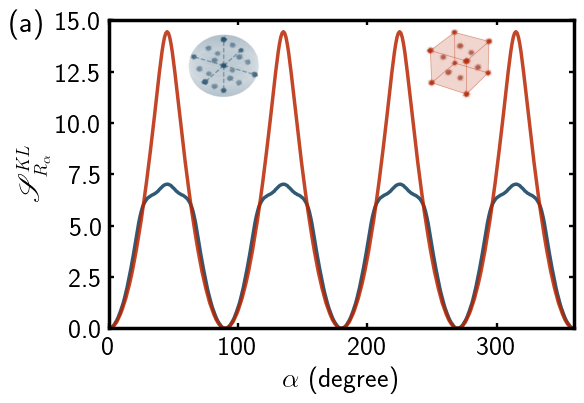

In [12]:
spheroid_measures_data = np.loadtxt(spheroid_filedir_KL, delimiter=',')
cubic_measures_data = np.loadtxt(cubic_filedir_KL, delimiter=',')
plot_compare(x=spheroid_measures_data[:,0], y1=spheroid_measures_data[:,1], y2=cubic_measures_data[:,1],
             xlim=[angles[0], angles[-1]], ylim=[0,15], xlabel=r'$\alpha$ (degree)', ylabel=r'$\mathscr{S}^{\mathit{KL}}_{\mathit{R}_\alpha}$',
             subfigs_info={'../figs/nickel/spheroid_nickel_samples_nobackground.pdf': [0.23, 0.68, 0.17, 0.17],
                           '../figs/nickel/cubic_solid_nickel_samples_nobackground.pdf': [0.62, 0.68, 0.18, 0.18]},
             text={'content':'(a)', 'loc':[-0.04, .85, 0, 0]}, 
             style=bg_mpl_style, save_filedir='../figs/nickel/rotation_spheroid_vs_cubic_solid_KL.pdf')

## Ellipsoid and rectangular solid - KL

Ellipsoid:
The symmetry breaking measure for rotating angle 90 degree is: 20.669088095716603.
The symmetry breaking measure for rotating angle 180 degree is: -1.1211992763352217e-15.
The symmetry breaking measure for rotating angle 270 degree is: 20.669088095716603.
The symmetry breaking measure for the C4 operator is: 13.779392063811068
Rectangular:
The symmetry breaking measure for rotating angle 90 degree is: 15.951687270668208.
The symmetry breaking measure for rotating angle 180 degree is: -3.203426503814918e-16.
The symmetry breaking measure for rotating angle 270 degree is: 15.951687270668204.
The symmetry breaking measure for the C4 operator is: 10.63445818044547


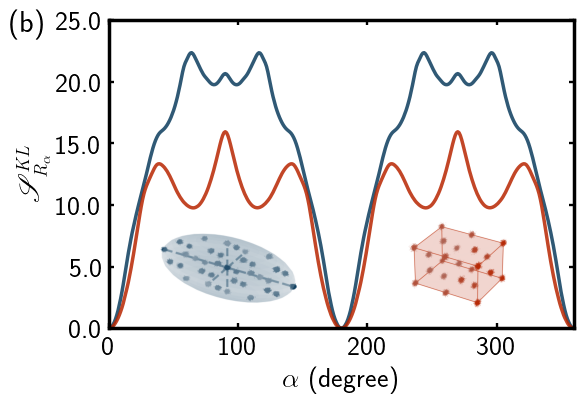

In [14]:
ellipsoid_measures_data = np.loadtxt(ellipsoid_filedir_KL, delimiter=',')
rectangular_measures_data = np.loadtxt(rectangular_filedir_KL, delimiter=',')
print("Ellipsoid:")
calc_sbm_C4(ellipsoid_measures_data)
print("Rectangular:")
calc_sbm_C4(rectangular_measures_data)
plot_compare(x=ellipsoid_measures_data[:,0], y1=ellipsoid_measures_data[:,1], y2=rectangular_measures_data[:,1],
             xlim=[angles[0], angles[-1]], ylim=[0,25.0], xlabel=r'$\alpha$ (degree)', ylabel=r'$\mathscr{S}^{\mathit{KL}}_{\mathit{R}_\alpha}$',
             subfigs_info={'../figs/nickel/ellipsoid_nickel_samples_nobackground.pdf': [0.205, 0.14, 0.24, 0.24],
                           '../figs/nickel/rectangular_solid_nickel_samples_nobackground.pdf': [0.585, 0.15, 0.24, 0.24]},
             text={'content':'(b)', 'loc':[-0.04, .85, 0, 0]}, 
             style=bg_mpl_style, save_filedir='../figs/nickel/rotation_ellipsoid_vs_rectangular_solid_KL.pdf')

## Spheroid and cubic solid - JS

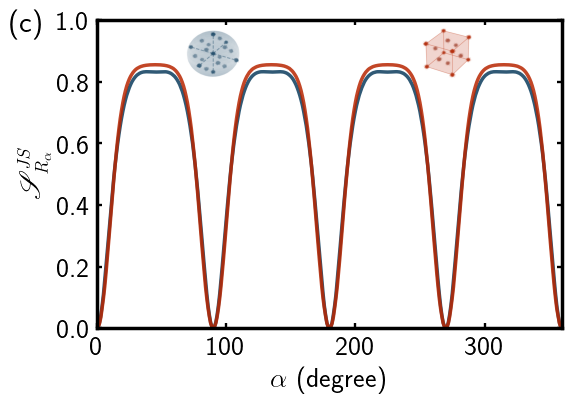

In [16]:
spheroid_measures_data = np.loadtxt(spheroid_filedir_JS, delimiter=',')
cubic_measures_data = np.loadtxt(cubic_filedir_JS, delimiter=',')
plot_compare(x=spheroid_measures_data[:,0], y1=spheroid_measures_data[:,1], y2=cubic_measures_data[:,1],
             xlim=[angles[0], angles[-1]], ylim=[0,1], xlabel=r'$\alpha$ (degree)', ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\mathit{R}_\alpha}$',
             subfigs_info={'../figs/nickel/spheroid_nickel_samples_nobackground.pdf': [0.254, 0.734, 0.127, 0.127],
                           '../figs/nickel/cubic_solid_nickel_samples_nobackground.pdf': [0.645, 0.734, 0.13, 0.13]},
             text={'content':'(c)', 'loc':[-0.02, .85, 0, 0]}, 
             style=bg_mpl_style, save_filedir='../figs/nickel/rotation_spheroid_vs_cubic_solid_JS.pdf')

## Ellipsoid and rectangular solid

Ellipsoid:
The symmetry breaking measure for rotating angle 90 degree is: 0.48909985931366384.
The symmetry breaking measure for rotating angle 180 degree is: 1.7618845770982033e-15.
The symmetry breaking measure for rotating angle 270 degree is: 0.4890998593127297.
The symmetry breaking measure for the C4 operator is: 0.3260665728754651
Rectangular:
The symmetry breaking measure for rotating angle 90 degree is: 0.4364161849232989.
The symmetry breaking measure for rotating angle 180 degree is: -4.930380657631324e-32.
The symmetry breaking measure for rotating angle 270 degree is: 0.43641618492273493.
The symmetry breaking measure for the C4 operator is: 0.2909441232820113


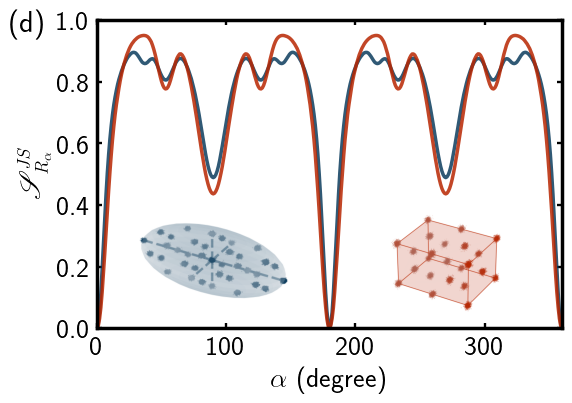

In [17]:
ellipsoid_measures_data = np.loadtxt(ellipsoid_filedir_JS, delimiter=',')
rectangular_measures_data = np.loadtxt(rectangular_filedir_JS, delimiter=',')
print("Ellipsoid:")
calc_sbm_C4(ellipsoid_measures_data)
print("Rectangular:")
calc_sbm_C4(rectangular_measures_data)
plot_compare(x=ellipsoid_measures_data[:,0], y1=ellipsoid_measures_data[:,1], y2=rectangular_measures_data[:,1],
             xlim=[angles[0], angles[-1]], ylim=[0,1], xlabel=r'$\alpha$ (degree)', ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\mathit{R}_\alpha}$',
             subfigs_info={'../figs/nickel/ellipsoid_nickel_samples_nobackground.pdf': [0.19, 0.15, 0.26, 0.26],
                           '../figs/nickel/rectangular_solid_nickel_samples_nobackground.pdf': [0.57, 0.14, 0.27, 0.27]},
             text={'content':'(d)', 'loc':[-0.02, .85, 0, 0]}, 
             style=bg_mpl_style, save_filedir='../figs/nickel/rotation_ellipsoid_vs_rectangular_solid_JS.pdf')